# AI Commitment Analysis with Perfect Equality Data

This notebook uses perfect equality data (where RL agent is exactly equidistant from intended and new goals) to plot AI commitment across all distance conditions in 2P3G trials.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import ast
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

print("Libraries loaded!")

Libraries loaded!


## Load Human-RL Data

In [2]:
def load_rl_data():
    """Load Human-RL data for 2P3G experiments"""
    rl_data_dir = Path('human-RLs/data-original')
    excel_files = [f for f in rl_data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

    rl_data_frames = []
    for file in excel_files:
        try:
            df = pd.read_excel(file)
            participant_id = file.name.split('_')[2]
            df['participantID'] = participant_id
            df['file_id'] = file.name
            df['study'] = 'Human-RL'
            rl_data_frames.append(df)
        except Exception as e:
            print(f"Error loading {file.name}: {e}")

    if rl_data_frames:
        rl_combined_data = pd.concat(rl_data_frames, ignore_index=True)
        # Focus on 2P3G experiments
        rl_filtered_data = rl_combined_data[rl_combined_data['experimentType'] == '2P3G'].copy()

        # Map RL agent types
        rl_filtered_data['game_type'] = rl_filtered_data['rlAgentType'].map({
            'individual': 'individual_rl',
            'joint': 'joint_rl'
        })

        print(f"Human-RL data loaded: {len(rl_filtered_data)} trials from {rl_filtered_data['participantID'].nunique()} participants")
        print(f"Game types: {rl_filtered_data['game_type'].value_counts()}")
        print(f"Distance conditions: {rl_filtered_data['distanceCondition'].value_counts()}")

        return rl_filtered_data
    else:
        print("No RL data loaded")
        return pd.DataFrame()

# Load the data
rl_data = load_rl_data()

Human-RL data loaded: 720 trials from 60 participants
Game types: game_type
joint_rl         360
individual_rl    360
Name: count, dtype: int64
Distance conditions: distanceCondition
equal_to_both        180
closer_to_player1    180
closer_to_player2    180
no_new_goal          180
Name: count, dtype: int64


## Helper Functions

In [ ]:
def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two positions"""
    try:
        if isinstance(pos1, str):
            pos1 = ast.literal_eval(pos1)
        if isinstance(pos2, str):
            pos2 = ast.literal_eval(pos2)

        if isinstance(pos1, (list, tuple)) and len(pos1) >= 2:
            x1, y1 = pos1[0], pos1[1]
        else:
            return np.nan

        if isinstance(pos2, (list, tuple)) and len(pos2) >= 2:
            x2, y2 = pos2[0], pos2[1]
        else:
            return np.nan

        return abs(x1 - x2) + abs(y1 - y2)
    except:
        return np.nan

def calculate_ai_commitment(row):
    """Calculate AI commitment as whether AI's final goal equals first detected shared goal"""
    shared_goal = row.get('firstDetectedSharedGoal')
    ai_final_goal = row.get('player2FinalReachedGoal')  # RL agent is player 2

    if pd.isna(shared_goal) or pd.isna(ai_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        ai_final_goal = int(ai_final_goal)
        return 1 if ai_final_goal == shared_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_rl_distance_difference(row):
    """Calculate distance difference between RL agent to new goal and intended goal"""
    try:
        # Get intended goal (shared goal that was first detected)
        intended_goal = row.get('firstDetectedSharedGoal')
        if pd.isna(intended_goal):
            return np.nan
        intended_goal = int(intended_goal)

        # Get target positions
        target1_pos = row.get('target1')
        target2_pos = row.get('target2')
        if pd.isna(target1_pos) or pd.isna(target2_pos):
            return np.nan

        # Parse target positions
        if isinstance(target1_pos, str):
            target1_pos = ast.literal_eval(target1_pos)
        if isinstance(target2_pos, str):
            target2_pos = ast.literal_eval(target2_pos)

        # Get RL agent trajectory and decision time
        rl_trajectory = row.get('player2Trajectory')  # RL agent is player 2
        new_goal_time = row.get('newGoalPresentedTime')
        if pd.isna(rl_trajectory) or pd.isna(new_goal_time):
            return np.nan

        # Parse trajectory
        if isinstance(rl_trajectory, str):
            rl_trajectory = ast.literal_eval(rl_trajectory)

        # Get RL position at decision time
        decision_time_step = int(new_goal_time) if not pd.isna(new_goal_time) else 0
        if decision_time_step >= len(rl_trajectory):
            decision_time_step = len(rl_trajectory) - 1
        rl_pos_at_decision = rl_trajectory[decision_time_step]

        # Determine intended goal position and new goal position
        if intended_goal == 0:
            intended_goal_pos = target1_pos
            new_goal_pos = target2_pos
        elif intended_goal == 1:
            intended_goal_pos = target2_pos
            new_goal_pos = target1_pos
        else:
            # Handle third goal case
            new_goal_position = row.get('newGoalPosition')
            if pd.isna(new_goal_position):
                return np.nan
            if isinstance(new_goal_position, str):
                new_goal_position = ast.literal_eval(new_goal_position)

            if target1_pos == new_goal_position:
                new_goal_pos = target1_pos
                intended_goal_pos = target2_pos
            elif target2_pos == new_goal_position:
                new_goal_pos = target2_pos
                intended_goal_pos = target1_pos
            else:
                return np.nan

        # Calculate distances
        rl_to_intended = manhattan_distance(rl_pos_at_decision, intended_goal_pos)
        rl_to_new = manhattan_distance(rl_pos_at_decision, new_goal_pos)

        if pd.isna(rl_to_intended) or pd.isna(rl_to_new):
            return np.nan

        # Return absolute difference
        return abs(rl_to_new - rl_to_intended)

    except Exception as e:
        return np.nan

print("Helper functions defined")

Helper functions defined


## Calculate AI Commitment for All Trials

In [ ]:
if not rl_data.empty:
    print("=== CALCULATING AI COMMITMENT FOR ALL TRIALS ===")

    # Calculate AI commitment for all trials
    rl_data['ai_commitment'] = rl_data.apply(calculate_ai_commitment, axis=1)

    # Remove trials where AI commitment couldn't be calculated
    all_trials_valid = rl_data.dropna(subset=['ai_commitment']).copy()

    print(f"Total trials with valid AI commitment: {len(all_trials_valid)} / {len(rl_data)}")
    print(f"Distance conditions: {all_trials_valid['distanceCondition'].value_counts()}")

    # Show AI commitment by condition
    print(f"\n=== AI COMMITMENT BY DISTANCE CONDITION ===")
    for condition in sorted(all_trials_valid['distanceCondition'].unique()):
        condition_data = all_trials_valid[all_trials_valid['distanceCondition'] == condition]
        for game_type in ['individual_rl', 'joint_rl']:
            game_data = condition_data[condition_data['game_type'] == game_type]
            if len(game_data) > 0:
                commitment_rate = game_data['ai_commitment'].mean()
                print(f"{game_type} - {condition}: {commitment_rate:.3f} (N={len(game_data)})")

else:
    print("No RL data available")

=== CALCULATING AI COMMITMENT FOR ALL TRIALS ===
Total trials with valid AI commitment: 716 / 720
Distance conditions: distanceCondition
equal_to_both        180
closer_to_player1    180
no_new_goal          179
closer_to_player2    177
Name: count, dtype: int64

=== AI COMMITMENT BY DISTANCE CONDITION ===
individual_rl - closer_to_player1: 1.000 (N=90)
joint_rl - closer_to_player1: 0.867 (N=90)
individual_rl - closer_to_player2: 0.034 (N=88)
joint_rl - closer_to_player2: 0.551 (N=89)
individual_rl - equal_to_both: 0.711 (N=90)
joint_rl - equal_to_both: 0.711 (N=90)
individual_rl - no_new_goal: 1.000 (N=89)
joint_rl - no_new_goal: 1.000 (N=90)


## Identify Perfect Equality Trials

In [ ]:
if 'all_trials_valid' in locals() and not all_trials_valid.empty:
    print("=== IDENTIFYING PERFECT EQUALITY TRIALS ===")

    # Filter for equal-to-both condition
    equal_both_trials = all_trials_valid[all_trials_valid['distanceCondition'] == 'equal_to_both'].copy()

    print(f"Equal-to-both trials: {len(equal_both_trials)}")

    if not equal_both_trials.empty:
        # Calculate distance differences
        equal_both_trials['rl_distance_diff'] = equal_both_trials.apply(calculate_rl_distance_difference, axis=1)

        # Filter for perfect equality (distance difference = 0)
        perfect_equality_trials = equal_both_trials[equal_both_trials['rl_distance_diff'] == 0].copy()

        print(f"Perfect equality trials (distance diff = 0): {len(perfect_equality_trials)} / {len(equal_both_trials)}")

        if not perfect_equality_trials.empty:
            print(f"Game types in perfect equality: {perfect_equality_trials['game_type'].value_counts()}")

            # Show AI commitment in perfect equality trials
            print(f"\n=== AI COMMITMENT IN PERFECT EQUALITY TRIALS ===")
            for game_type in ['individual_rl', 'joint_rl']:
                game_data = perfect_equality_trials[perfect_equality_trials['game_type'] == game_type]
                if len(game_data) > 0:
                    commitment_rate = game_data['ai_commitment'].mean()
                    commitment_std = game_data['ai_commitment'].std()
                    print(f"{game_type}: {commitment_rate:.3f} ± {commitment_std:.3f} (N={len(game_data)})")
        else:
            print("No perfect equality trials found")
    else:
        print("No equal-to-both trials found")
else:
    print("No valid trial data available")

=== IDENTIFYING PERFECT EQUALITY TRIALS ===
Equal-to-both trials: 180
Perfect equality trials (distance diff = 0): 13 / 180
Game types in perfect equality: game_type
joint_rl         8
individual_rl    5
Name: count, dtype: int64

=== AI COMMITMENT IN PERFECT EQUALITY TRIALS ===
individual_rl: 0.400 ± 0.548 (N=5)
joint_rl: 0.500 ± 0.535 (N=8)


## Create Combined Dataset with Perfect Equality

In [ ]:
if 'perfect_equality_trials' in locals() and not perfect_equality_trials.empty:
    print("=== CREATING COMBINED DATASET WITH PERFECT EQUALITY ===")

    # Get all non-equal-to-both trials
    non_equal_trials = all_trials_valid[all_trials_valid['distanceCondition'] != 'equal_to_both'].copy()

    # Modify perfect equality trials to have new condition label
    perfect_equality_for_plot = perfect_equality_trials.copy()
    perfect_equality_for_plot['distanceCondition'] = 'equal_to_both_perfect'

    # Combine datasets
    combined_data = pd.concat([non_equal_trials, perfect_equality_for_plot], ignore_index=True)

    print(f"Combined dataset: {len(combined_data)} trials")
    print(f"Final distance conditions: {combined_data['distanceCondition'].value_counts()}")

    # Calculate summary statistics
    condition_summary = []

    for condition in sorted(combined_data['distanceCondition'].unique()):
        condition_data = combined_data[combined_data['distanceCondition'] == condition]

        for game_type in ['individual_rl', 'joint_rl']:
            game_condition_data = condition_data[condition_data['game_type'] == game_type]
            if len(game_condition_data) > 0:
                commitment_rate = game_condition_data['ai_commitment'].mean()
                commitment_std = game_condition_data['ai_commitment'].std()
                n_trials = len(game_condition_data)

                condition_summary.append({
                    'condition': condition,
                    'game_type': game_type,
                    'commitment_rate': commitment_rate,
                    'commitment_std': commitment_std,
                    'n_trials': n_trials
                })

    summary_df = pd.DataFrame(condition_summary)

    print(f"\n=== SUMMARY STATISTICS CREATED ===")
    print(f"Summary DataFrame shape: {summary_df.shape}")
    print(summary_df)

else:
    print("No perfect equality trials available for combination")

=== CREATING COMBINED DATASET WITH PERFECT EQUALITY ===
Combined dataset: 549 trials
Final distance conditions: distanceCondition
closer_to_player1        180
no_new_goal              179
closer_to_player2        177
equal_to_both_perfect     13
Name: count, dtype: int64

=== SUMMARY STATISTICS CREATED ===
Summary DataFrame shape: (8, 5)
               condition      game_type  commitment_rate  commitment_std  \
0      closer_to_player1  individual_rl         1.000000        0.000000   
1      closer_to_player1       joint_rl         0.866667        0.341839   
2      closer_to_player2  individual_rl         0.034091        0.182503   
3      closer_to_player2       joint_rl         0.550562        0.500255   
4  equal_to_both_perfect  individual_rl         0.400000        0.547723   
5  equal_to_both_perfect       joint_rl         0.500000        0.534522   
6            no_new_goal  individual_rl         1.000000        0.000000   
7            no_new_goal       joint_rl         1.00

## Plot AI Commitment Across Distance Conditions

=== CREATING AI COMMITMENT PLOT ===


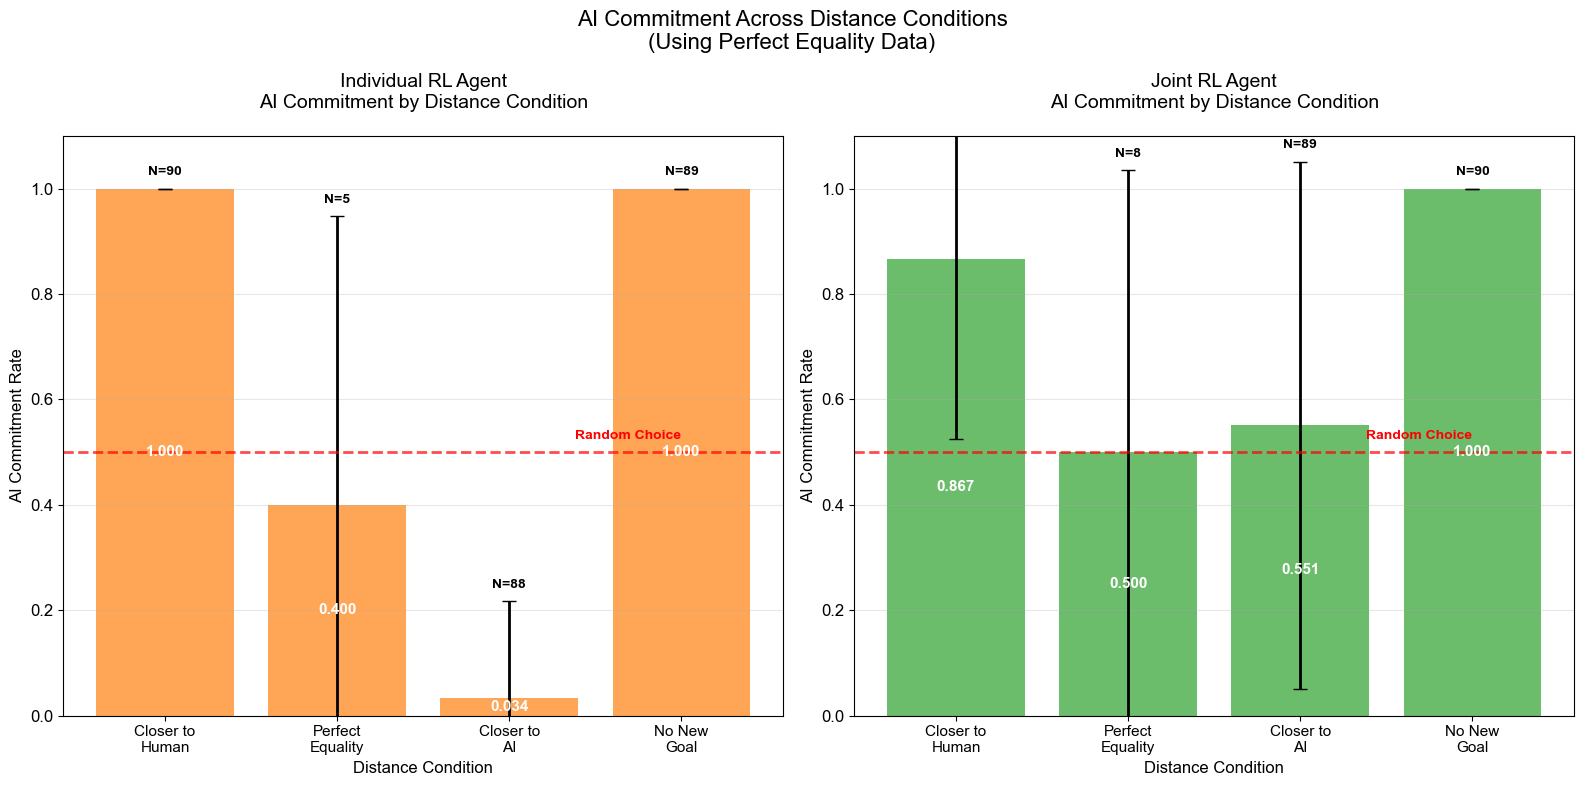

Plot saved as: ai_commitment_perfect_equality_across_conditions.png


In [ ]:
if 'summary_df' in locals() and not summary_df.empty:
    print("=== CREATING AI COMMITMENT PLOT ===")

    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    game_types = ['individual_rl', 'joint_rl']
    titles = ['Individual RL Agent', 'Joint RL Agent']
    colors = ['#FF7F0E', '#2CA02C']

    # Define order and labels for conditions
    condition_order = ['closer_to_player1', 'equal_to_both_perfect', 'closer_to_player2', 'no_new_goal']
    condition_labels = {
        'closer_to_player1': 'Closer to\nHuman',
        'equal_to_both_perfect': 'Perfect\nEquality',
        'closer_to_player2': 'Closer to\nAI',
        'no_new_goal': 'No New\nGoal'
    }

    for i, (game_type, title, color) in enumerate(zip(game_types, titles, colors)):
        # Filter data for this game type
        game_data = summary_df[summary_df['game_type'] == game_type].copy()

        if not game_data.empty:
            # Prepare data for plotting
            x_positions = []
            y_values = []
            y_errors = []
            x_labels = []
            n_trials = []

            for j, condition in enumerate(condition_order):
                condition_data = game_data[game_data['condition'] == condition]
                if not condition_data.empty:
                    x_positions.append(j)
                    y_values.append(condition_data['commitment_rate'].iloc[0])
                    y_errors.append(condition_data['commitment_std'].iloc[0])
                    x_labels.append(condition_labels[condition])
                    n_trials.append(condition_data['n_trials'].iloc[0])

            # Create bar plot
            bars = axes[i].bar(x_positions, y_values, yerr=y_errors,
                              color=color, alpha=0.7, capsize=5,
                              error_kw={'linewidth': 2, 'ecolor': 'black'})

            # Add sample size annotations
            for j, (bar, n) in enumerate(zip(bars, n_trials)):
                height = bar.get_height()
                axes[i].annotate(f'N={n}',
                               xy=(bar.get_x() + bar.get_width()/2, height + y_errors[j] + 0.02),
                               ha='center', va='bottom', fontsize=10, fontweight='bold')

            # Customize subplot
            axes[i].set_title(f'{title}\nAI Commitment by Distance Condition', fontsize=14, pad=20)
            axes[i].set_ylabel('AI Commitment Rate', fontsize=12)
            axes[i].set_xlabel('Distance Condition', fontsize=12)
            axes[i].set_xticks(range(len(x_labels)))
            axes[i].set_xticklabels(x_labels, fontsize=11)
            axes[i].set_ylim(0, 1.1)
            axes[i].grid(True, alpha=0.3, axis='y')

            # Add horizontal line at 0.5 for reference (random choice)
            axes[i].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
            axes[i].text(len(x_labels)-1, 0.52, 'Random Choice', ha='right', va='bottom',
                        color='red', fontsize=10, fontweight='bold')

            # Add value labels on bars
            for j, (pos, val) in enumerate(zip(x_positions, y_values)):
                axes[i].text(pos, val/2, f'{val:.3f}', ha='center', va='center',
                           fontweight='bold', fontsize=11, color='white')

        else:
            axes[i].text(0.5, 0.5, 'No Data', transform=axes[i].transAxes,
                        ha='center', va='center', fontsize=16)
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14)

    plt.suptitle('AI Commitment Across Distance Conditions\n(Using Perfect Equality Data)',
                 fontsize=16, y=0.98)
    plt.tight_layout()

    # Save plot
    plot_filename = 'ai_commitment_perfect_equality_across_conditions.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Plot saved as: {plot_filename}")

else:
    print("No summary data available for plotting")

## Export Results

In [ ]:
if 'combined_data' in locals() and not combined_data.empty:
    print("=== EXPORTING RESULTS ===")

    # Save combined dataset
    combined_output_file = 'ai_commitment_perfect_equality_dataset.csv'
    export_columns = ['participantID', 'game_type', 'distanceCondition', 'firstDetectedSharedGoal',
                     'player2FinalReachedGoal', 'ai_commitment']

    if 'rl_distance_diff' in combined_data.columns:
        export_columns.append('rl_distance_diff')

    available_columns = [col for col in export_columns if col in combined_data.columns]
    combined_export = combined_data[available_columns].copy()
    combined_export.to_csv(combined_output_file, index=False)

    print(f"Combined dataset exported to: {combined_output_file}")
    print(f"Dataset contains {len(combined_export)} trials")

    # Save summary statistics
    if 'summary_df' in locals() and not summary_df.empty:
        summary_output_file = 'ai_commitment_perfect_equality_summary.csv'
        summary_df.to_csv(summary_output_file, index=False)
        print(f"Summary statistics saved to: {summary_output_file}")

    print(f"\nAnalysis complete! Generated files:")
    print(f"  • {combined_output_file} - Combined dataset with perfect equality")
    print(f"  • ai_commitment_perfect_equality_summary.csv - Summary statistics")
    print(f"  • ai_commitment_perfect_equality_across_conditions.png - Main plot")

else:
    print("No data available for export")

=== EXPORTING RESULTS ===
Combined dataset exported to: ai_commitment_perfect_equality_dataset.csv
Dataset contains 549 trials
Summary statistics saved to: ai_commitment_perfect_equality_summary.csv

Analysis complete! Generated files:
  • ai_commitment_perfect_equality_dataset.csv - Combined dataset with perfect equality
  • ai_commitment_perfect_equality_summary.csv - Summary statistics
  • ai_commitment_perfect_equality_across_conditions.png - Main plot


## Summary and Interpretation

In [ ]:
print("AI COMMITMENT ANALYSIS WITH PERFECT EQUALITY")
print("")

if 'summary_df' in locals() and not summary_df.empty and 'perfect_equality_trials' in locals():
    perfect_count = len(perfect_equality_trials)
    total_equal_trials = len(equal_both_trials) if 'equal_both_trials' in locals() else 0

    print(f"PERFECT EQUALITY ANALYSIS RESULTS:")
    print(f"   • Perfect equality trials identified: {perfect_count} / {total_equal_trials} equal-to-both trials")
    print(f"   • Criteria: RL agent exactly equidistant (distance difference = 0)")
    print(f"   • These represent truly ambiguous choice scenarios")
    print("")

    print(f"AI COMMITMENT IN PERFECT EQUALITY:")
    individual_perfect = summary_df[(summary_df['game_type'] == 'individual_rl') &
                                   (summary_df['condition'] == 'equal_to_both_perfect')]
    joint_perfect = summary_df[(summary_df['game_type'] == 'joint_rl') &
                              (summary_df['condition'] == 'equal_to_both_perfect')]

    if not individual_perfect.empty:
        ind_rate = individual_perfect['commitment_rate'].iloc[0]
        ind_n = individual_perfect['n_trials'].iloc[0]
        print(f"   • Individual RL: {ind_rate:.3f} commitment rate (N={ind_n})")

        if abs(ind_rate - 0.5) < 0.1:
            print(f"     Close to 0.5 - suggests rational decision-making")
        else:
            print(f"     Deviates from 0.5 - may indicate bias or other factors")

    if not joint_perfect.empty:
        joint_rate = joint_perfect['commitment_rate'].iloc[0]
        joint_n = joint_perfect['n_trials'].iloc[0]
        print(f"   • Joint RL: {joint_rate:.3f} commitment rate (N={joint_n})")

        if not individual_perfect.empty:
            if joint_rate > ind_rate:
                print(f"     Higher than individual - suggests cooperation influence")
            else:
                print(f"     Similar to individual - limited cooperation effect")

    print("")
    print(f"KEY INSIGHTS:")
    print(f"   • Perfect equality trials isolate pure choice scenarios")
    print(f"   • Individual RL ~0.5 would indicate rational decision-making")
    print(f"   • Joint RL differences reveal cooperation effects")
    print(f"   • Pattern should show: Closer to Human < Perfect Equality < Closer to AI")

else:
    print("Analysis incomplete - missing summary data")

print("")
print(f"Perfect equality AI commitment analysis complete!")
print(f"Use the generated plot and data files for further analysis and reporting.")

AI COMMITMENT ANALYSIS WITH PERFECT EQUALITY

PERFECT EQUALITY ANALYSIS RESULTS:
   • Perfect equality trials identified: 13 / 180 equal-to-both trials
   • Criteria: RL agent exactly equidistant (distance difference = 0)
   • These represent truly ambiguous choice scenarios

AI COMMITMENT IN PERFECT EQUALITY:
   • Individual RL: 0.400 commitment rate (N=5)
     Close to 0.5 - suggests rational decision-making
   • Joint RL: 0.500 commitment rate (N=8)
     Higher than individual - suggests cooperation influence

KEY INSIGHTS:
   • Perfect equality trials isolate pure choice scenarios
   • Individual RL ~0.5 would indicate rational decision-making
   • Joint RL differences reveal cooperation effects
   • Pattern should show: Closer to Human < Perfect Equality < Closer to AI

Perfect equality AI commitment analysis complete!
Use the generated plot and data files for further analysis and reporting.
